## 1. Load Dependant Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

## 2. Setup Directories

In [2]:
mainDIR = os.listdir('./images')
train_folder= './images/train/'
test_folder = './images/test/'

train_n = train_folder+'NORMAL/'
train_p = train_folder+'PNEUMONIA/'

tot_normal_train = len(os.listdir(train_n))
tot_pneumonia_train = len(os.listdir(train_p))
print('total normal xray images: ', tot_normal_train)
print('total pneumonia xray images: ', tot_pneumonia_train)

total normal xray images:  1349
total pneumonia xray images:  3883


## 3. Load Images into Keras and split into Train, Validation and Test

In [3]:
target_size = (128, 128)
input_shape = (128, 128, 3)
batch_size = 32

print("Train Dataset....")
train_dir = tf.keras.preprocessing.image_dataset_from_directory(train_folder, 
                                                                image_size=target_size, 
                                                                batch_size=batch_size,
                                                                shuffle=True,
                                                                label_mode='binary',
                                                                validation_split=0.2,
                                                                subset='training',
                                                                seed=101)



print("Validation Dataset....")
val_dir = tf.keras.preprocessing.image_dataset_from_directory(train_folder, 
                                                              image_size=target_size, 
                                                              batch_size=batch_size,
                                                              label_mode='binary',
                                                              subset='validation',
                                                              validation_split=0.2,
                                                              seed=101)

print("Test Dataset...")
test_dir = tf.keras.preprocessing.image_dataset_from_directory(test_folder, 
                                                               image_size=target_size, 
                                                               batch_size=batch_size, 
                                                               label_mode='binary',
                                                               seed=101)

Train Dataset....
Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Validation Dataset....
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Test Dataset...
Found 624 files belonging to 2 classes.


In [5]:
autotune = tf.data.AUTOTUNE ### most important function for speed up training


train_data_batches = train_dir.cache().prefetch(buffer_size=autotune)
valid_data_batches = val_dir.cache().prefetch(buffer_size=autotune)
test_data_batches = test_dir.cache().prefetch(buffer_size=autotune)

## 4. Create, Compile and Train Model

In [6]:
model_1 = tf.keras.models.Sequential()
model_1.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape))
model_1.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model_1.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))
model_1.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model_1.add(tf.keras.layers.Flatten())
model_1.add(tf.keras.layers.Dense(activation = 'relu', units = 128))
model_1.add(tf.keras.layers.Dense(activation = 'sigmoid', units = 1))

model_1.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy', 
                metrics = ['accuracy'])

history_1 = model_1.fit(train_data_batches,
                         epochs = 50,
                         batch_size=batch_size,
                         validation_data = valid_data_batches)

Epoch 1/50
131/131 [==============================] - 12s 33ms/step - loss: 11.8483 - accuracy: 0.8832 - val_loss: 0.1506 - val_accuracy: 0.9493
Epoch 2/50
131/131 [==============================] - 1s 5ms/step - loss: 0.1194 - accuracy: 0.9613 - val_loss: 0.1553 - val_accuracy: 0.9522
Epoch 3/50
131/131 [==============================] - 1s 4ms/step - loss: 0.0874 - accuracy: 0.9699 - val_loss: 0.1521 - val_accuracy: 0.9608
Epoch 4/50
131/131 [==============================] - 1s 4ms/step - loss: 0.0361 - accuracy: 0.9888 - val_loss: 0.1729 - val_accuracy: 0.9598
Epoch 5/50
131/131 [==============================] - 1s 4ms/step - loss: 0.0201 - accuracy: 0.9931 - val_loss: 0.2214 - val_accuracy: 0.9579
Epoch 6/50
131/131 [==============================] - 1s 4ms/step - loss: 0.0137 - accuracy: 0.9964 - val_loss: 0.1573 - val_accuracy: 0.9665
Epoch 7/50
131/131 [==============================] - 1s 4ms/step - loss: 0.0093 - accuracy: 0.9964 - val_loss: 0.1822 - val_accuracy: 0.9608
Epo

## 9. Visualize Model Metrics

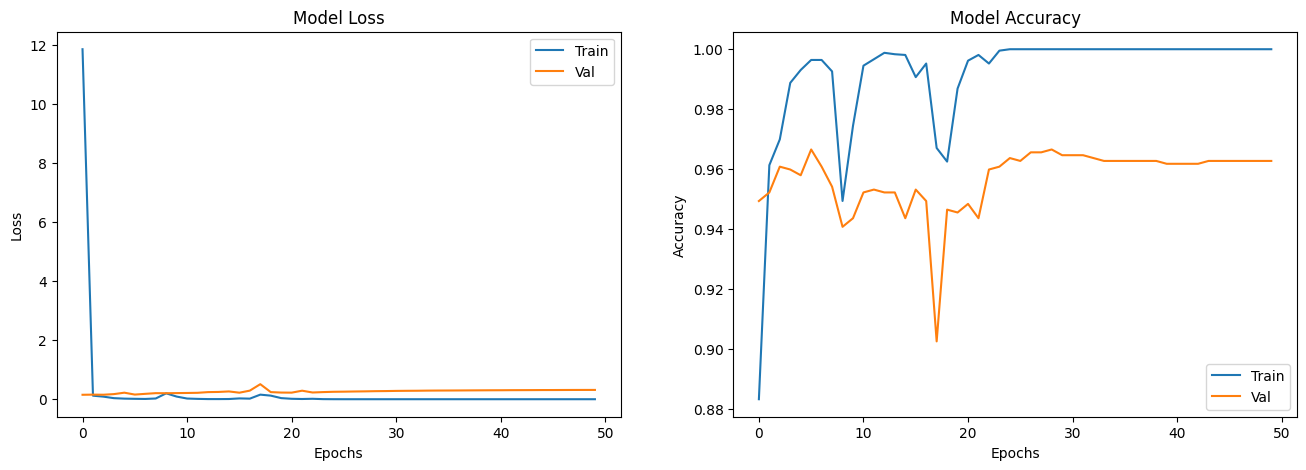

In [7]:
model_results = pd.DataFrame(history_1.history)
model_results.columns

plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(model_results['loss'])
plt.plot(model_results['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'])

plt.subplot(1, 2, 2)
plt.plot(model_results['accuracy'])
plt.plot(model_results['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'])

## Tune-Model-1 (Compensate for Class Imbalance)

In [8]:
tot_normal_train = len(os.listdir(train_n)) 
tot_pneumonia_train = len(os.listdir(train_p))
print ('Total Normal X-Ray Images: ', tot_normal_train)
print ('Total Pneumonia X-Ray Train Images: ', tot_pneumonia_train)

freq_neg = tot_normal_train/(tot_normal_train + tot_pneumonia_train)
freq_pos = tot_pneumonia_train/(tot_normal_train + tot_pneumonia_train)

pos_weights = np.array([freq_neg])
neg_weights = np.array([freq_pos])

class_weights_k = {0:tot_normal_train, 1: tot_pneumonia_train}

print ('\ncheck positive weight: ', pos_weights)
print ('check negative weight: ', neg_weights)

Total Normal X-Ray Images:  1349
Total Pneumonia X-Ray Train Images:  3883

check positive weight:  [0.25783639]
check negative weight:  [0.74216361]


In [9]:
model_2 = tf.keras.models.Sequential()
model_2.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape))
model_2.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model_2.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))
model_2.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model_2.add(tf.keras.layers.Flatten())
model_2.add(tf.keras.layers.Dense(activation = 'relu', units = 128))
model_2.add(tf.keras.layers.Dense(activation = 'sigmoid', units = 1))

model_2.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy', 
                metrics = ['accuracy'])

history_2 = model_2.fit(train_data_batches,
                         epochs = 50,
                         batch_size=batch_size,
                         validation_data = valid_data_batches,
                         class_weight=class_weights_k)

Epoch 1/50
131/131 [==============================] - 1s 7ms/step - loss: 26329.8066 - accuracy: 0.8607 - val_loss: 0.1568 - val_accuracy: 0.9551
Epoch 2/50
131/131 [==============================] - 1s 4ms/step - loss: 338.8926 - accuracy: 0.9410 - val_loss: 0.2446 - val_accuracy: 0.9283
Epoch 3/50
131/131 [==============================] - 1s 4ms/step - loss: 330.4900 - accuracy: 0.9424 - val_loss: 0.2495 - val_accuracy: 0.9226
Epoch 4/50
131/131 [==============================] - 1s 4ms/step - loss: 168.1293 - accuracy: 0.9666 - val_loss: 0.2118 - val_accuracy: 0.9551
Epoch 5/50
131/131 [==============================] - 1s 4ms/step - loss: 172.8833 - accuracy: 0.9673 - val_loss: 0.2371 - val_accuracy: 0.9312
Epoch 6/50
131/131 [==============================] - 1s 4ms/step - loss: 133.3004 - accuracy: 0.9747 - val_loss: 0.1885 - val_accuracy: 0.9541
Epoch 7/50
131/131 [==============================] - 1s 4ms/step - loss: 63.3791 - accuracy: 0.9878 - val_loss: 0.1804 - val_accuracy

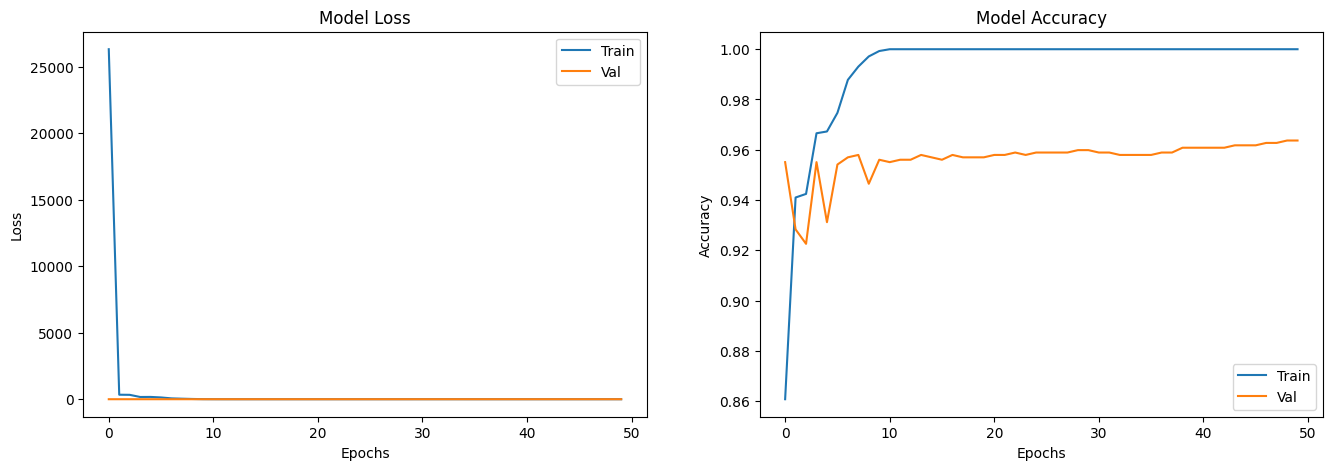

In [10]:
model_results = pd.DataFrame(history_2.history)
model_results.columns

plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(model_results['loss'])
plt.plot(model_results['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'])

plt.subplot(1, 2, 2)
plt.plot(model_results['accuracy'])
plt.plot(model_results['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'])

## Tune-Model-2 (Add Image Augmentation)

In [11]:
model_3 = tf.keras.models.Sequential()
model_3.add(tf.keras.Sequential([tf.keras.layers.Rescaling(1./255)]))
model_3.add(
  tf.keras.Sequential
([
  tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(factor=10), 
  tf.keras.layers.RandomZoom(0.2)
])
)
model_3.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape))
model_3.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model_3.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))
model_3.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model_3.add(tf.keras.layers.Flatten())
model_3.add(tf.keras.layers.Dense(activation = 'relu', units = 128))
model_3.add(tf.keras.layers.Dense(activation = 'sigmoid', units = 1))

model_3.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy', 
                metrics = ['accuracy'])

history_3 = model_3.fit(train_data_batches,
                         epochs = 50,
                         batch_size=batch_size,
                         validation_data = valid_data_batches,
                         class_weight=class_weights_k)

Epoch 1/50
131/131 [==============================] - 14s 94ms/step - loss: 1223.6654 - accuracy: 0.7394 - val_loss: 0.4810 - val_accuracy: 0.7715
Epoch 2/50
131/131 [==============================] - 11s 87ms/step - loss: 844.9764 - accuracy: 0.7864 - val_loss: 0.3493 - val_accuracy: 0.8480
Epoch 3/50
131/131 [==============================] - 12s 88ms/step - loss: 717.7136 - accuracy: 0.8244 - val_loss: 0.3256 - val_accuracy: 0.8576
Epoch 4/50
131/131 [==============================] - 12s 89ms/step - loss: 697.6674 - accuracy: 0.8290 - val_loss: 0.2776 - val_accuracy: 0.8862
Epoch 5/50
131/131 [==============================] - 12s 91ms/step - loss: 677.2057 - accuracy: 0.8354 - val_loss: 0.3927 - val_accuracy: 0.8011
Epoch 6/50
131/131 [==============================] - 12s 90ms/step - loss: 656.9090 - accuracy: 0.8438 - val_loss: 0.3553 - val_accuracy: 0.8423
Epoch 7/50
131/131 [==============================] - 12s 90ms/step - loss: 612.4725 - accuracy: 0.8564 - val_loss: 0.2439 

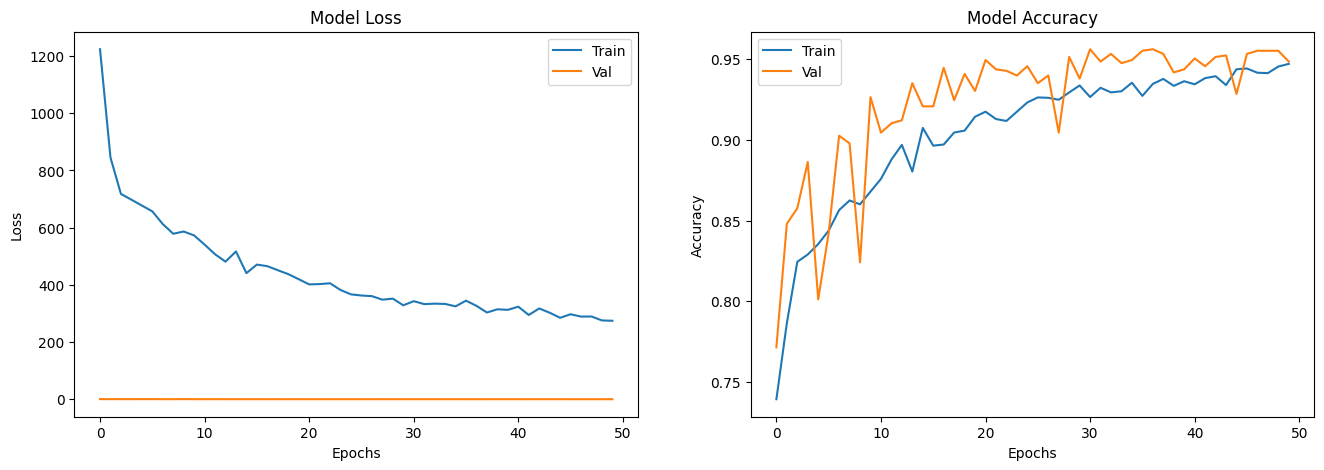

In [12]:
model_results = pd.DataFrame(history_3.history)
model_results.columns

plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(model_results['loss'])
plt.plot(model_results['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'])

plt.subplot(1, 2, 2)
plt.plot(model_results['accuracy'])
plt.plot(model_results['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'])

## Tune-Model-3 (Load Pre-Trained Covnet - Resnet v2)

In [13]:
inception_resnet_v2 = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False,
                                                                                weights="imagenet",
                                                                                input_shape=input_shape)

In [14]:
inception_resnet_v2.trainable = True
set_trainable = False

for layer in inception_resnet_v2.layers:
  if layer.name == 'block8_10_conv':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [15]:
for layer in inception_resnet_v2.layers:
    print(layer.name,layer.trainable)

input_1 False
conv2d_8 False
batch_normalization False
activation False
conv2d_9 False
batch_normalization_1 False
activation_1 False
conv2d_10 False
batch_normalization_2 False
activation_2 False
max_pooling2d_8 False
conv2d_11 False
batch_normalization_3 False
activation_3 False
conv2d_12 False
batch_normalization_4 False
activation_4 False
max_pooling2d_9 False
conv2d_16 False
batch_normalization_8 False
activation_8 False
conv2d_14 False
conv2d_17 False
batch_normalization_6 False
batch_normalization_9 False
activation_6 False
activation_9 False
average_pooling2d False
conv2d_13 False
conv2d_15 False
conv2d_18 False
conv2d_19 False
batch_normalization_5 False
batch_normalization_7 False
batch_normalization_10 False
batch_normalization_11 False
activation_5 False
activation_7 False
activation_10 False
activation_11 False
mixed_5b False
conv2d_23 False
batch_normalization_15 False
activation_15 False
conv2d_21 False
conv2d_24 False
batch_normalization_13 False
batch_normalization_16 

In [16]:
model_4 = tf.keras.models.Sequential()
model_4.add(tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)]))
model_4.add(tf.keras.Sequential
([
  tf.keras.layers.experimental.preprocessing.RandomFlip(),
  tf.keras.layers.experimental.preprocessing.RandomRotation(10), 
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1) 
  ]))
model_4.add(inception_resnet_v2)
model_4.add(tf.keras.layers.Flatten())
model_4.add(tf.keras.layers.Dense(activation = 'relu', units = 128))
model_4.add(tf.keras.layers.Dense(activation = 'sigmoid', units = 1))

model_4.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

history_4 = model_4.fit(train_data_batches, 
                    epochs=50, 
                    validation_data=valid_data_batches,
                    class_weight=class_weights_k)

Epoch 1/50
131/131 [==============================] - 22s 113ms/step - loss: 929.5470 - accuracy: 0.7774 - val_loss: 0.2906 - val_accuracy: 0.8815
Epoch 2/50
131/131 [==============================] - 13s 99ms/step - loss: 598.7609 - accuracy: 0.8464 - val_loss: 0.2251 - val_accuracy: 0.9101
Epoch 3/50
131/131 [==============================] - 13s 101ms/step - loss: 505.5011 - accuracy: 0.8801 - val_loss: 0.2047 - val_accuracy: 0.9149
Epoch 4/50
131/131 [==============================] - 13s 100ms/step - loss: 444.0114 - accuracy: 0.8978 - val_loss: 0.1924 - val_accuracy: 0.9235
Epoch 5/50
131/131 [==============================] - 13s 100ms/step - loss: 431.2559 - accuracy: 0.8980 - val_loss: 0.1658 - val_accuracy: 0.9293
Epoch 6/50
131/131 [==============================] - 13s 99ms/step - loss: 395.4114 - accuracy: 0.9073 - val_loss: 0.1539 - val_accuracy: 0.9321
Epoch 7/50
131/131 [==============================] - 13s 99ms/step - loss: 397.0047 - accuracy: 0.9104 - val_loss: 0.16

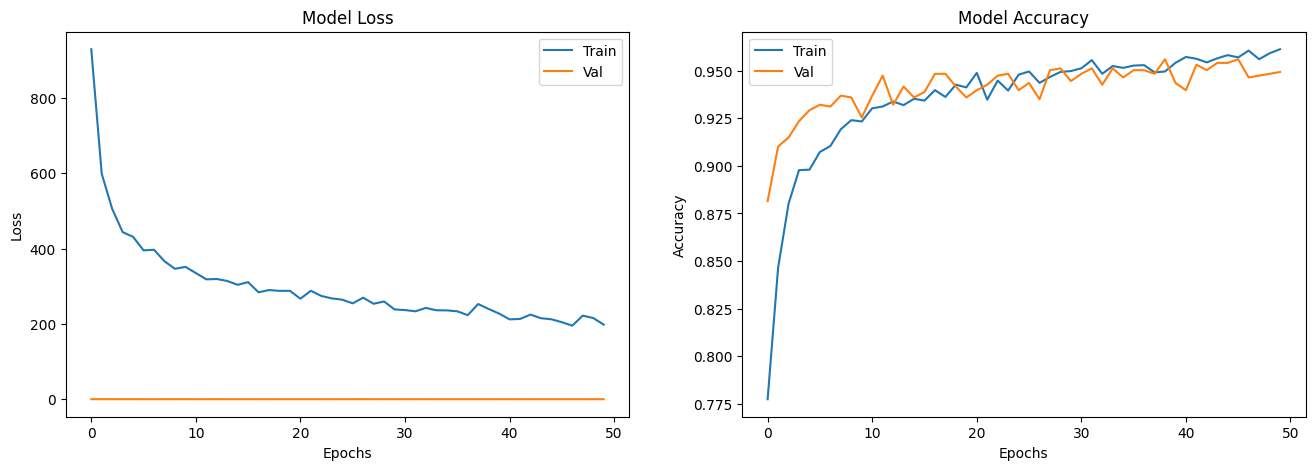

In [17]:
model_results = pd.DataFrame(history_4.history)
model_results.columns

plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(model_results['loss'])
plt.plot(model_results['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'])

plt.subplot(1, 2, 2)
plt.plot(model_results['accuracy'])
plt.plot(model_results['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'])

## Create and Plot ROC and AUC on Test Data

### Check for Optimal ROC Threshold

- The optimal cut off would be where tpr is high and fpr is low
- tpr - (1-fpr) is zero or near to zero is the optimal cut off point

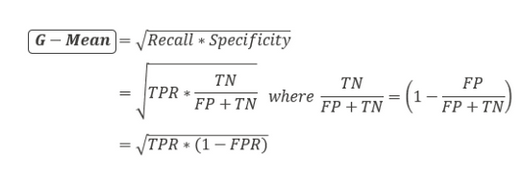

In [18]:
test_class_vals = tf.concat([y for x, y in test_data_batches], axis=0)

Threshold value is: 0.9824828


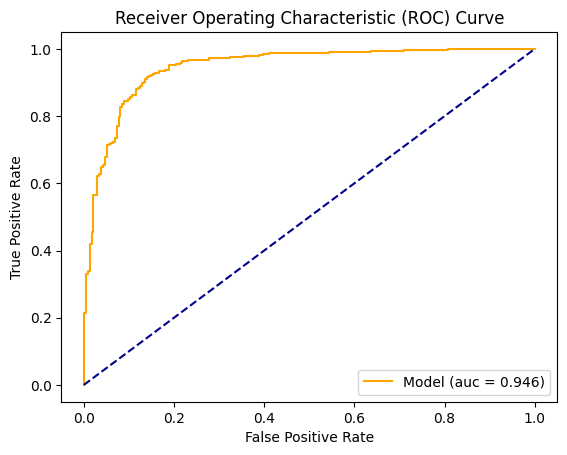

In [19]:
def plot_roc_curve(fpr, tpr):
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label='Model (auc = %0.3f)'%model_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

fpr, tpr, thresholds = roc_curve(test_class_vals, model_4.predict(test_data_batches, verbose=0))
gmean = np.sqrt(tpr * (1 - fpr))
optimal_idx = np.argmax(gmean)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

## Evaluate the Selected Model and produce Metrics on Test Data

True Negative: 201  False Positive: 33
False Negative: 34     True Positive: 356


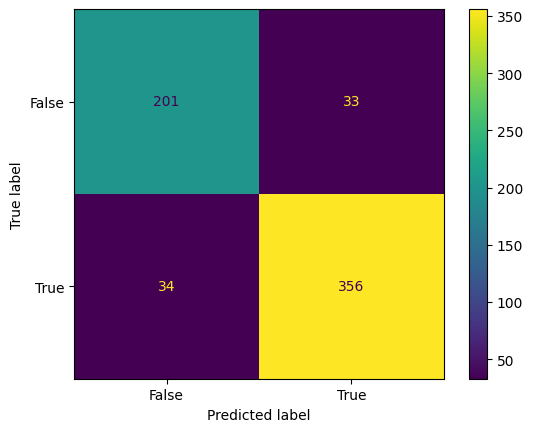

In [20]:
y_pred = np.where(model_4.predict(test_data_batches, verbose=0)>optimal_threshold, 1, 0)
cm = confusion_matrix(test_class_vals, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f'True Negative: {tn}  False Positive: {fp}\nFalse Negative: {fn}     True Positive: {tp}')
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

In [21]:
acc = accuracy_score(test_class_vals,y_pred)
prec = precision_score(test_class_vals,y_pred)
recl = recall_score(test_class_vals,y_pred)
f1_sc = f1_score(test_class_vals,y_pred)

print(f'Accuracy: {acc*100}\nPrecesion: {prec*100}\nRecall: {recl*100}\nF1-Score: {f1_sc*100}')

Accuracy: 89.26282051282051
Precesion: 91.51670951156812
Recall: 91.28205128205128
F1-Score: 91.3992297817715


In [23]:
model_4.save('model_5_2Feb.h5')